# 1.1 Install Dependencies and setup

In [16]:
# !pip install labelme tensorflow opencv-python matplotlib albumentations

labelme 5.4.1


# 1.2 collect images using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [18]:
# uuid operation (uniform unique id)
uuid.uuid1()

UUID('be32a2a3-ea9c-11ee-906a-b42e996e5f84')

In [2]:
IMAGE_PATH = os.path.join('data','images')
number_images=30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    ret, frame = cap.read()
    imgname=os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break;
cap.release()
cv2.destroyAllWindows()

# 1.3 Annotate Images with LabelMe

In [8]:
!labelme

2024-03-25 18:18:37,357 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Anonymous\.labelmerc


# 2. Review Dataset and build Image Loading Function

# 2.1 import TF and Deps     

In [10]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

# 2.2 Limit GPU memory growth

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [18]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2.3 Load Image into TF Data Pipeline

In [22]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=False)
images.as_numpy_iterator().next()

b'data\\images\\0004784a-eaa0-11ee-b8ea-b42e996e5f84.jpg'

In [23]:
def load_image(x):
    byte_img=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [24]:
images = images.map(load_image)

In [27]:
# images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

# 2.4 View Raw Images with Matplotlib

In [28]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

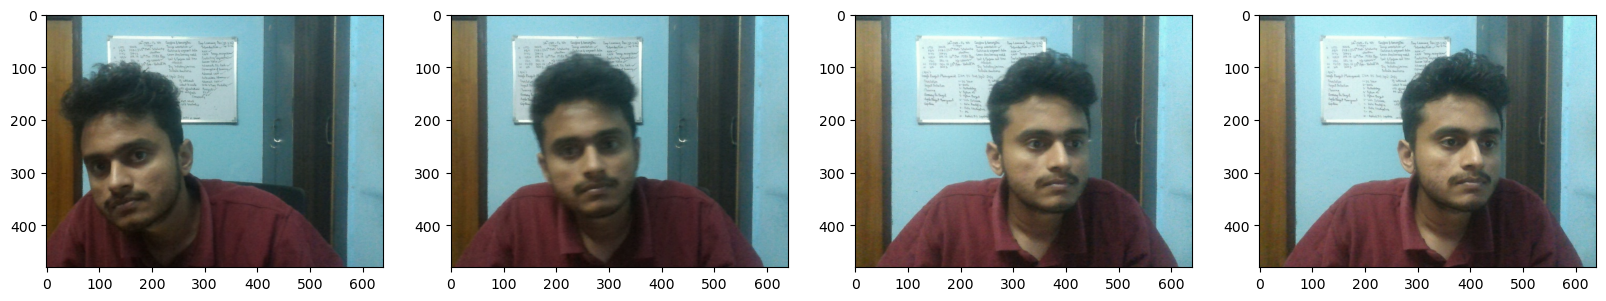

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data
- 70% training data - 63 images
- 14 images test and 13 images to validation 

# 3.2 Move the Matching labels

In [38]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split('.')[0]+'.json'
        existing_filepath=os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

# 4 Apply Image Augmentation on Images and Labels using Albumentations

In [41]:
import albumentations as alb

In [43]:
augmentator=alb.Compose([
    alb.RandomCrop(width=450,height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels'])                        
)

# 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [45]:
img=cv2.imread(os.path.join('data','train','images','02e28dea-eaa0-11ee-a6f5-b42e996e5f84.jpg'))


In [48]:
with open(os.path.join('data','train','labels','02e28dea-eaa0-11ee-a6f5-b42e996e5f84.json'),'r') as f:
    label=json.load(f)

In [53]:
label['shapes'][0]['points']

[[213.84615384615384, 86.15384615384616],
 [412.3076923076923, 368.46153846153845]]